In [1]:
import numpy as np
from skimage import io
from skimage.util import view_as_blocks
from scipy.fftpack import dct, idct
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

u1, v1 = 4, 5
u2, v2 = 5, 4
n = 8

def double_to_byte(arr):
    return np.uint8(np.round(np.clip(arr, 0, 255), 0))

def increment_abs(x):
    return x + 1 if x >= 0 else x - 1

def decrement_abs(x):
    if np.abs(x) <= 1:
        return 0
    else:
        return x - 1 if x >= 0 else x + 1
    
def text_to_bin(text):
    a = [f'{i:b}' for i in text.encode('ascii')]
    a = ''.join(a)
    return np.array([i == '1' for i in a]).astype('int')

def to_string(bytes_):
    return ''.join([chr(int(b, 2)) for b in [bytes_[i*7: i*7 + 7] for i in range(len(bytes_) // 7)]])

In [2]:
def abs_diff_coefs(transform):
    return abs(transform[u1, v1]) - abs(transform[u2, v2])

def valid_coefficients(transform, bit, threshold):
    difference = abs_diff_coefs(transform)
    if (bit == 0) and (difference > threshold):
        return True
    elif (bit == 1) and (difference < -threshold):
        return True
    else:
        return False

def change_coefficients(transform, bit):
    coefs = transform.copy()
    if bit == 0:
        coefs[u1, v1] = increment_abs(coefs[u1, v1])
        coefs[u2, v2] = decrement_abs(coefs[u2, v2])
    elif bit == 1:
        coefs[u1, v1] = decrement_abs(coefs[u1, v1])
        coefs[u2, v2] = increment_abs(coefs[u2, v2])
    return coefs

In [3]:
def embed_bit(block, bit, P):
    patch = block.copy()
    coefs = dct(dct(patch, axis=0), axis=1)
    while not valid_coefficients(coefs, bit, P) or (bit != retrieve_bit(patch)):
        coefs = change_coefficients(coefs, bit)
        #print (coefs[u1, v1], coefs[u2, v2])
        patch = double_to_byte(idct(idct(coefs, axis=0), axis=1)/(2*n)**2)
    return patch

def embed_message(orig, msg, P):
    changed = orig.copy()
    blue = changed[:, :, 2]
    blocks = view_as_blocks(blue, block_shape=(n, n))
    h = blocks.shape[1]        
    for index, bit in enumerate(msg):
        #print ('index=%d, bit=%d' % (index, bit))
        i = index // h
        j = index % h
        block = blocks[i, j]
        blue[i*n: (i+1)*n, j*n: (j+1)*n] = embed_bit(block, bit, P)
    changed[:, :, 2] = blue
    return changed

In [4]:
def retrieve_bit(block):
    transform = dct(dct(block, axis=0), axis=1)
    return 0 if abs_diff_coefs(transform) > 0 else 1

def retrieve_message(img, length):
    blocks = view_as_blocks(img[:, :, 2], block_shape=(n, n))
    h = blocks.shape[1]
    return [retrieve_bit(blocks[index//h, index%h]) for index in range(length)]

In [5]:
in_filename = 'img_kz/kitten_1000.jpg'
out_filename = 'img_kz/kitten_out.jpg'
img_original = io.imread(in_filename)
test_message = text_to_bin("Steganography")
img_changed = embed_message(img_original, test_message, 20)
io.imsave(out_filename, img_changed)

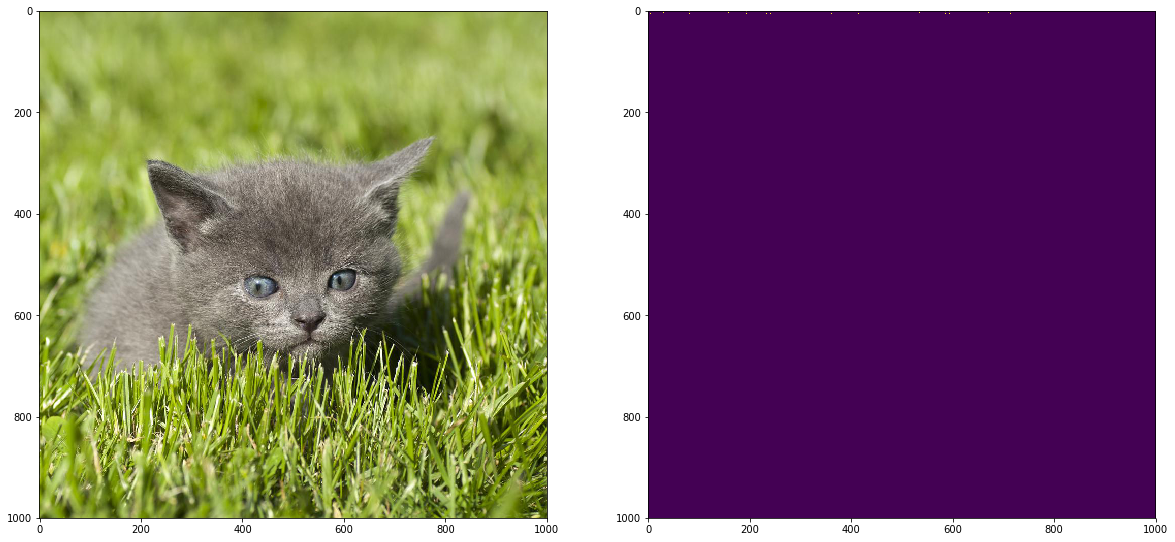

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(img_original)
axes[0].grid(False)

axes[1].imshow(img_original[:, :, 2] - img_changed[:, :, 2])
axes[1].grid(False)



In [7]:
payload_message = np.asarray(retrieve_message(img_changed, len(test_message)))
np.array_equal(payload_message, test_message)

True

In [8]:
to_string(''.join([str(m) for m in payload_message]))

'Steganography'

In [9]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err
mse(img_original, img_changed)

0.000244

In [10]:
mse(img_original, embed_message(img_original, test_message, 1000))

0.352352